<a href="https://colab.research.google.com/github/zain711/dcipher/blob/main/IndianNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bertopic==0.6.0
!pip install bertopic[visualization]==0.6.0
!pip install bert-extractive-summarizer
!pip install plotly
#!pip install tensorflow,torch,flair
#!pip install bertopic[flair]
#!pip install bertopic[gensim]

In [ ]:
!pip install torch

In [ ]:
!pip install flair

In [ ]:
import json
import pandas as pd
import torch
from bertopic import BERTopic
import os
import nltk 
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer , WordNetLemmatizer
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install bertopic==0.6.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip list -v | grep bertopic

bertopic                      0.6.0          /usr/local/lib/python3.7/dist-packages pip      


## **Preprocessing Text**

In [ ]:
#previous vaccine forums
data = pd.read_json('/content/drive/MyDrive/IndianNews-minified.json')
docs_raw = list(data.loc[:, "text"].values)
times = list(data.loc[:, "date"].values)

In [ ]:
data.head(5)

,date,text
0,2021-03-30 18:28:49+00:00,The Haryana born athlete says she took solace ...
1,2021-03-30 18:26:51+00:00,and anxiety . Here is a list of food items t...
2,2021-03-30 18:24:17+00:00,"” According to Architectural Record, numerou..."
3,2021-03-30 18:08:48+00:00,Count on this simple breathing exercise to rel...
4,2021-03-30 18:02:23+00:00,It's become a place where I find most of my ne...


In [ ]:
import re
wnl = WordNetLemmatizer()
ps = PorterStemmer()

#tokens = list(data.loc[:, "tokens"].values)
docs = []
for_embed = []
rem_num = []
my_tokens = []

docs_lower = [k.lower() for k in docs_raw]
#remove numbers and symbols from token list and lemmatize
for b in docs_lower:
  rem_num.append(re.sub('[0-9]+', '', b)) #remove numerical tokens

for a in rem_num:
  docs.append(re.sub(r'[^\w]', ' ', a))

#for c in new_tokens:
  #my_tokens.append(" ".join([wnl.lemmatize(a) for a in c.split()]))

#split tokens for word embeddings
for c in docs:
  for_embed.append(c.split())

In [ ]:
#clean times for topic evolution visualization
clean_times = []
for a in times:
  ts = pd.to_datetime(str(a)) 
  d = ts.strftime('%Y.%m')
  clean_times.append(d)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt 

#calculate and graph loss of embeddings
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
        self.epochs = []
        self.losses = []

    def on_epoch_end(self, modeling):
        plt.axis([0, 100, 0, 3000000])
        loss = modeling.running_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        epochs = self.epoch
        losses = loss_now
        plt.plot(self.epoch, loss_now, '.r-')
        self.epoch += 1
        if (self.epoch == 100):
           plt.show()

# **FINE TUNED FASTTEXT MODEL**

In [ ]:
!pip install gensim==4.0.0b

In [ ]:
from gensim.models.fasttext import FastText, load_facebook_model, save_facebook_model
from multiprocessing import cpu_count
from typing import List
from math import log10
import numpy as np
from gensim.test.utils import datapath

model_path = "/content/drive/MyDrive/english.bin"
model = load_facebook_model(datapath(model_path))
model.workers = cpu_count() - 2

In [ ]:
model.build_vocab(corpus_iterable=for_embed, update=False, keep_raw_vocab=False)

In [ ]:
num_docs = len(for_embed)
num_tokens = sum([len(doc) for doc in for_embed])
num_epochs = min(round(100.0 / (log10(num_docs + 1) + 1e-5)), 100)

In [ ]:
model.train(corpus_iterable=for_embed,
            total_examples=num_docs,
            total_words=num_tokens,
            epochs=num_epochs)

In [ ]:
# save model
save_facebook_model(model, "finetuned_model2.bin")

In [ ]:
# After training the model
# 1. Word vector extraction
def get_word_vector(word):
    return model.wv.get_vector(word)

# 2. Sentence vector extraction
def get_sentence_vector(text: List[str]):
    def div_norm(x):
        norm_value = np.linalg.norm(x)
        if norm_value > 0:
            return x * (1.0 / norm_value)
        else:
            return x
    
    token_vectors = np.array([div_norm(get_word_vector(token))
                                  for token in text if len(token) > 0])

    if len(token_vectors) == 0:
        return np.zeros(100)

    return np.mean(token_vectors, axis=0)

In [ ]:
word_vectors = model.wv
word_vectors.save("/content/drive/My Drive/fasttext_finetune_indian2")

In [ ]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/fasttext_finetune_indian2")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [ ]:
topic_model = BERTopic(nr_topics=10, embedding_model=document_glove_embeddings)

In [ ]:
topics, prob = topic_model.fit_transform(docs)

In [ ]:
#remove stop words and change n-gram range
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

stop_word =['don', 'doesn', 'didn', 'isn', 'aren','https', 'won', 'haven']
stop_words = text.ENGLISH_STOP_WORDS.union(stop_word)
cv = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words)
topic_model.update_topics(docs, topics, vectorizer_model=cv)

In [ ]:
topic_model.get_topics()

{-1: [('health', 0.03443959299121839),
  ('mental', 0.03403817077024237),
  ('anxiety', 0.031189220247965103),
  ('people', 0.018964651759475114),
  ('stress', 0.01515734644673795),
  ('issues', 0.012995398248701873),
  ('covid', 0.01225536207720684),
  ('pandemic', 0.011299282922853206),
  ('children', 0.008662062534497984),
  ('lockdown', 0.0076449174827984585)],
 9: [('area', 0.13225895207225438),
  ('bengal', 0.10179289382139614),
  ('south', 0.0669238411560801),
  ('arabian', 0.06266466330201403),
  ('east', 0.054741902812112574),
  ('north', 0.05253564607289842),
  ('cyclone', 0.050076884516799106),
  ('coast', 0.04783141886067855),
  ('cyclonic', 0.04593646249695769),
  ('southeast', 0.0358680981628936)],
 257: [('anxiety', 0.06076275560795435),
  ('lockdown', 0.017159873081612934),
  ('people', 0.015679972511943616),
  ('state', 0.014054738607453406),
  ('coronavirus', 0.012999898273146864),
  ('students', 0.012863998884253844),
  ('covid', 0.011912802698355615),
  ('india', 0.

In [ ]:
topic_model.save('/content/drive/My Drive/indian_ft_finettune1')
np.save('/content/drive/My Drive/topic_indiafine1', topics)

In [ ]:
topic_model = BERTopic.load('/content/drive/My Drive/indian_ft_finettune1')
topics = np.load('/content/drive/My Drive/topic_indiafine1.npy')

In [ ]:
topics_over_time = topic_model.topics_over_time(docs, topics, clean_times, global_tuning=False)

In [ ]:
topics_over_time = topics_over_time[topics_over_time.Topic != -1]

In [ ]:
y = topics_over_time.groupby(["Topic",'Timestamp']).agg({"Words": ', '.join})
local = y.values.tolist()

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
y

Words
Topic Timestamp                                                    
9     2019-03-01  accidents, frequency, incidents, immediate, fr...
      2019-04-01       bengal, equatorial, area, southeast, cyclone
      2019-05-01                   low, area, weather, bay, cyclone
      2019-06-01       area, arabian, north, meteorological, bengal
      2019-07-01               bengal, heavy, rainfall, area, north
      2019-08-01              bengal, heavy, rainfall, area, odisha
      2019-09-01                arabian, area, gujarat, east, coast
      2019-10-01                  low, area, arabian, bengal, coast
      2019-11-01              area, bengal, andaman, cyclone, north
      2019-12-01            arabian, area, east, south, lakshadweep
      2020-01-01        conduit, continent, crossed, central, south
      2020-02-01     galvanized, galveston, galway, galore, gallows
      2020-03-01            marginal, rain, weather, showers, south
      2020-04-01                     andaman, low, south, sea, area
      2020-05-01            area, arabian, south, southeast, bengal
      2020-06-01             area, arabian, east, cyclone, cyclonic
      2020-07-01                bengal, coast, area, north, cyclone
      2020-08-01                 bengal, heavy, area, north, odisha
      2020-09-01                cyclone, area, west, rainfall, east
      2020-10-01                  bengal, area, north, west, odisha
      2020-11-01          bengal, area, south, puducherry, cyclonic
      2020-12-01         area, heavy, ramanathapuram, kerala, rains
      2021-01-01  rainfall, sholinganallur, weather, pradesh, mo...
      2021-03-01                  oyster, frontal, east, north, low
257   2019-04-01          anxiety, range, treatment, used, charging
      2019-05-01           anxiety, range, results, gauge, electric
      2019-06-01       anxiety, range, electric, vehicles, charging
      2019-07-01      anxiety, range, charging, wimbledon, dangling
      2019-08-01           range, gauge, highest, india, volatility
      2019-09-01  anxiety, translated, india, bachelet, uncertainty
      2019-10-01  range, charging, electric, infrastructure, veh...
      2019-11-01        anxiety, study, viewing, researchers, reset
      2019-12-01       range, anxiety, charging, india, citizenship
      2020-01-01        anxiety, charging, students, range, digital
      2020-02-01          board, anxiety, range, examiner, students
      2020-03-01        anxiety, fear, people, feeling, researchers
      2020-04-01       secular, telegram, backseat, israeli, lesson
      2020-05-01    anxiety, students, lockdown, covid, coronavirus
      2020-06-01       anxiety, covid, students, minister, pandemic
      2020-07-01          anxiety, students, results, covid, people
      2020-08-01       anxiety, students, people, fear, uncertainty
      2020-09-01            anxiety, singh, priyanka, delhi, mumbai
      2020-10-01           anxiety, covid, pandemic, stress, issues
      2020-11-01          anxiety, covid, states, daytime, pandemic
      2020-12-01  anxiety, brahmaputra, riparian, bangladesh, fo...
      2021-01-01        anxiety, range, electric, charging, battery
      2021-02-01  anxiety, range, loneliness, charging, infrastr...
      2021-03-01        range, anxiety, electric, battery, charging
268   2019-03-01  induced, printable, archana, handicapped, gyna...
      2019-04-01        modesty, mental, health, strongly, governed
      2019-05-01        mental, health, address, publishing, issues
      2019-06-01      health, mental, fortis, sciences, behavioural
      2019-07-01               mental, health, people, care, fortis
      2019-08-01          tighter, mass, wider, proposed, shootings
      2019-09-01         mental, health, suicide, people, awareness
      2019-10-01       mental, health, awareness, issues, important
      2019-11-01           mental, health, issues, players, cricket
      2019-12-01        health, mental, humbled, d

In [ ]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
0,-1,"children, issues, problems, bodied, neurodevel...",10,2019-03-01,-1_health_mental_anxiety_people
1,9,"accidents, frequency, incidents, immediate, fr...",1,2019-03-01,9_area_bengal_south_arabian
2,268,"induced, printable, archana, handicapped, gyna...",2,2019-03-01,268_mental_health_people_physical
3,552,"carries, involves, resilience, expert, wellness",2,2019-03-01,552_health_mental_pandemic_issues
4,796,"prosocial, experiment, increase, anxiety, gamble",1,2019-03-01,796_anxiety_people_feeling_stress
...,...,...,...,...,...
263,552,"health, mental, pandemic, issues, covid",213,2021-03-01,552_health_mental_pandemic_issues
264,571,"anxiety, stress, burnout, sleep, reduce",53,2021-03-01,571_anxiety_stress_people_depression
265,692,"blood, heart, disease, high, levels",72,2021-03-01,692_blood_levels_cholesterol_disease
266,796,"anxiety, people, mental, health, physical",63,2021-03-01,796_anxiety_people_feeling_stress


In [ ]:
y = topics_over_time.drop(columns = 'Topic')

In [ ]:
y.groupby(["Timestamp"]).sum(["Frequency"])

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n=10)

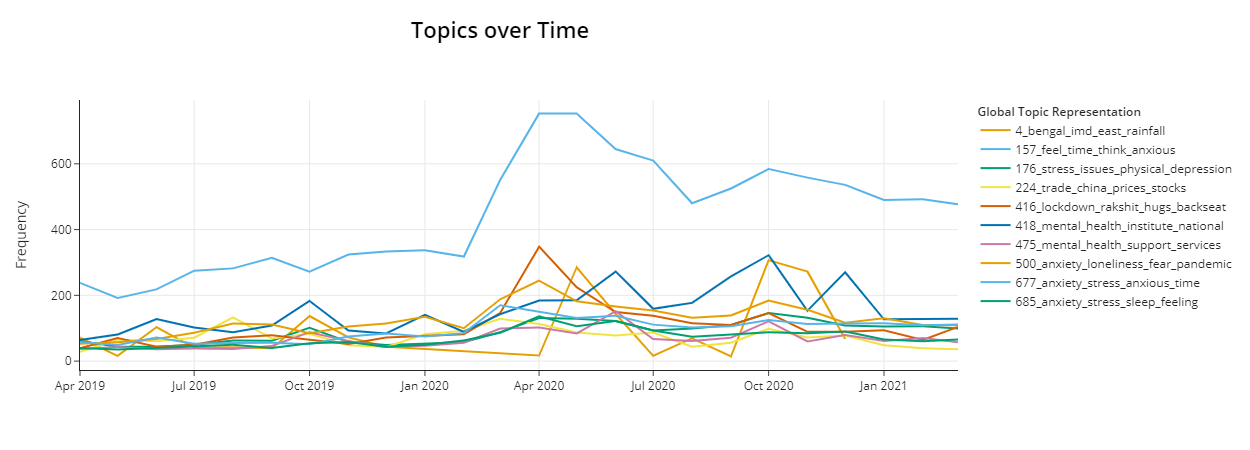

# **TRAINING W2V AND FT MODELS**

Loss after epoch 0: 4525649.5
Loss after epoch 1: 3430574.5
Loss after epoch 2: 3001672.0
Loss after epoch 3: 2852769.0
Loss after epoch 4: 2864706.0
Loss after epoch 5: 2493349.0
Loss after epoch 6: 2402002.0
Loss after epoch 7: 2457836.0
Loss after epoch 8: 2401782.0
Loss after epoch 9: 2438248.0
Loss after epoch 10: 2440576.0
Loss after epoch 11: 2347484.0
Loss after epoch 12: 1550228.0
Loss after epoch 13: 1610844.0
Loss after epoch 14: 1607412.0
Loss after epoch 15: 1585752.0
Loss after epoch 16: 1596256.0
Loss after epoch 17: 1555612.0
Loss after epoch 18: 1602172.0
Loss after epoch 19: 1573992.0
Loss after epoch 20: 1597016.0
Loss after epoch 21: 1618408.0
Loss after epoch 22: 1575648.0
Loss after epoch 23: 1583132.0
Loss after epoch 24: 1576980.0
Loss after epoch 25: 1582132.0
Loss after epoch 26: 1621072.0
Loss after epoch 27: 1612820.0
Loss after epoch 28: 1575340.0
Loss after epoch 29: 1612036.0
Loss after epoch 30: 1574592.0
Loss after epoch 31: 1639188.0
Loss after epoch 3

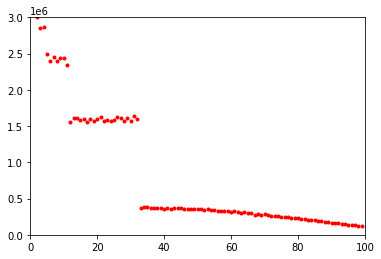

(638423966, 831529000)

In [ ]:
model = Word2Vec(window = 5, min_count = 10) #increase min_count
model.build_vocab(for_embed)  # prepare the model vocabulary
model.train(for_embed, total_examples=model.corpus_count, epochs=100, compute_loss = True, callbacks=[callback()])

In [ ]:
#save word2vec embeddings for model training
word_vectors = model.wv
word_vectors.save("/content/drive/My Drive/word2vec_indian")

In [ ]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/word2vec_indian")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [ ]:
from gensim.models import FastText 

modeling = FastText(size=100, window=5, min_count=10) 
modeling.build_vocab(sentences=for_embed)
modeling.train(for_embed, total_examples=len(for_embed), epochs=100, sg = 1, compute_loss=True)  # set sg = 1

In [ ]:
word_vectorss = modeling.wv
word_vectorss.save("/content/drive/My Drive/fasttext_indian2")

In [ ]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/fasttext_indian2")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [ ]:
topic_model = BERTopic(nr_topics=15, embedding_model=document_glove_embeddings)

In [ ]:
topics, prob = topic_model.fit_transform(new_tokens)

In [ ]:
#remove stop words and change n-gram range
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

stop_word =['don', 'doesn', 'didn', 'isn', 'aren', 'https', 'won', 'haven']
stop_words = text.ENGLISH_STOP_WORDS.union(stop_word)
cv = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words)
topic_model.update_topics(new_tokens, topics, vectorizer_model=cv)

In [ ]:
topic_model.get_topics()

In [ ]:
topics_over_time = topic_model.topics_over_time(docs, topics, clean_times, global_tuning=False)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n=10)

In [ ]:
topic_model.save('/content/drive/My Drive/indian_ft_finettune')

In [ ]:
np.save('/content/drive/My Drive/topic_indiafine', topics)
#np.save('/content/drive/My Drive/prob_india', prob)

In [ ]:
def get_topic_list(topic_model):
  dictionary = list(topic_model.get_topics().values())
  diction = dictionary[1:] #remove outlier topic
  p = 0
  final_t = []
  for i in range(len(diction)):
    final_t.append([])

  for key in diction:
     for i in key:
          final_t[p].append(i[0])
     p+=1
  return final_t

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
dictionary = corpora.Dictionary(for_embed)
corpus = [dictionary.doc2bow(text) for text in for_embed]

In [ ]:
y = topics_over_time.groupby("Topic").agg({"Words": ', '.join})
local = y.values.tolist()

In [ ]:
local = local[1:] #remove outlier topic

In [ ]:
local

[['accidents, frequency, incidents, immediate, frequent, bengal, equatorial, area, southeast, cyclone, low, area, weather, bay, cyclone, area, arabian, north, meteorological, bengal, bengal, heavy, rainfall, area, north, bengal, heavy, rainfall, area, odisha, arabian, area, gujarat, east, coast, low, area, arabian, bengal, coast, area, bengal, andaman, cyclone, north, arabian, area, east, south, lakshadweep, conduit, continent, crossed, central, south, galvanized, galveston, galway, galore, gallows, marginal, rain, weather, showers, south, andaman, low, south, sea, area, area, arabian, south, southeast, bengal, area, arabian, east, cyclone, cyclonic, bengal, coast, area, north, cyclone, bengal, heavy, area, north, odisha, cyclone, area, west, rainfall, east, bengal, area, north, west, odisha, bengal, area, south, puducherry, cyclonic, area, heavy, ramanathapuram, kerala, rains, rainfall, sholinganallur, weather, pradesh, monsoon, oyster, frontal, east, north, low'],
 ['anxiety, range, 

In [ ]:
b = []
p = 0
topics_local = []
for a in local:
  b.append(a[0].split())

for i in range(len(local)):
   topics_local.append([])

for c in b:
  for e in c:
    topics_local[p].append(e.replace(',', ''))
  p+=1

In [ ]:
cm = CoherenceModel(topics=topics_local, texts = for_embed, dictionary = dictionary, coherence='c_v')
coherence = cm.get_coherence()
coherence
# 5 - w2v 0.6189575597782422, ft 0.6412429685319271
# 10 - w2v 0.6222194350640053 and .5752088741711567, ft2 0.6786574184468597 and 0.5728454625710165, bert .5307728005165872 and 0.5822898612333395
# fine tuned - 0.612731160484963 and 0.5703466473032032

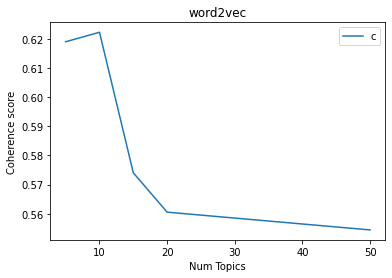

In [ ]:
# Show graph
import matplotlib.pyplot as plt
all_coherences = [0.618957559778242, 0.6222194350640053, 0.5740515670804616, 0.5605505700836383, 0.5544627155531007]
limit=40; start=2; step=6;
x = [5,10,15,20,50]
plt.plot(x, all_coherences)
plt.title("word2vec")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# **Results**

**Global Coherence Score Ranking**

1.   ft `0.6786574184468597` 
2.   w2v `0.6222194350640053  `
3.   ft fine-tuned `0.612731160484963` 
4.   distilbert `0.5307728005165872`

**Local Coherence Score Ranking**

1.   distilbert `0.5822898612333395`
2.   w2v `0.5752088741711567` 
3.   ft `0.572845462571016`
4.   ft fine-tuned `0.5703466473032032`


In [ ]:
topic_model = BERTopic(nr_topics = 10)

In [ ]:
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens")
embeddings = sentence_model.encode(new_tokens, show_progress_bar=True)

In [ ]:
embeddings = np.load("/content/drive/My Drive/bertbase_indian2.npy")

In [ ]:
topics, prob = topic_model.fit_transform(new_tokens, embeddings)

In [ ]:
bert_model = BERTopic.load('/content/drive/My Drive/indian_ftbert10')
bertop = np.load('/content/drive/My Drive/indian_berttop10.npy')

In [ ]:
#remove stop words and change n-gram range
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

stop_word =['don', 'doesn', 'didn', 'isn', 'aren', 'https', 'won', 'haven']
stop_words = text.ENGLISH_STOP_WORDS.union(stop_word)
cv = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words)
bert_model.update_topics(new_tokens,bertop, vectorizer_model=cv)

In [ ]:
bert_model.get_topics()

{-1: [('health', 0.034325476010140056),
  ('mental', 0.03396041533306874),
  ('anxiety', 0.030765426535391528),
  ('people', 0.019252149585031058),
  ('pressure', 0.015861383157900623),
  ('stress', 0.014923777310182405),
  ('issues', 0.012892102620263449),
  ('covid', 0.012649889636548117),
  ('help', 0.012522908046489927),
  ('pandemic', 0.012056737659641392),
  ('social', 0.011325855780126027),
  ('like', 0.011120390031751604),
  ('work', 0.009533528115020852),
  ('life', 0.009384731224922258),
  ('children', 0.008954306637200758),
  ('physical', 0.008943038722365295),
  ('day', 0.008886330313969959),
  ('anxious', 0.008871339339214539),
  ('students', 0.008654724580148366),
  ('study', 0.008635434258879745),
  ('lonely', 0.0085697906932749),
  ('loneliness', 0.008540251471194494),
  ('need', 0.00838745043483635),
  ('world', 0.008205465779057203),
  ('family', 0.008143179706206496),
  ('lockdown', 0.007926883593020333),
  ('home', 0.007872738119703602),
  ('care', 0.007672436792347

In [ ]:
topics_over_time = bert_model.topics_over_time(new_tokens, bertop, clean_times, global_tuning=False)

In [ ]:
topics_over = topics_over_time[topics_over_time.Frequency > 5]

In [ ]:
bert_model.visualize_topics_over_time(topics_over, top_n = 10)

/usr/local/lib/python3.7/dist-packages/bertopic/_bertopic.py:829: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



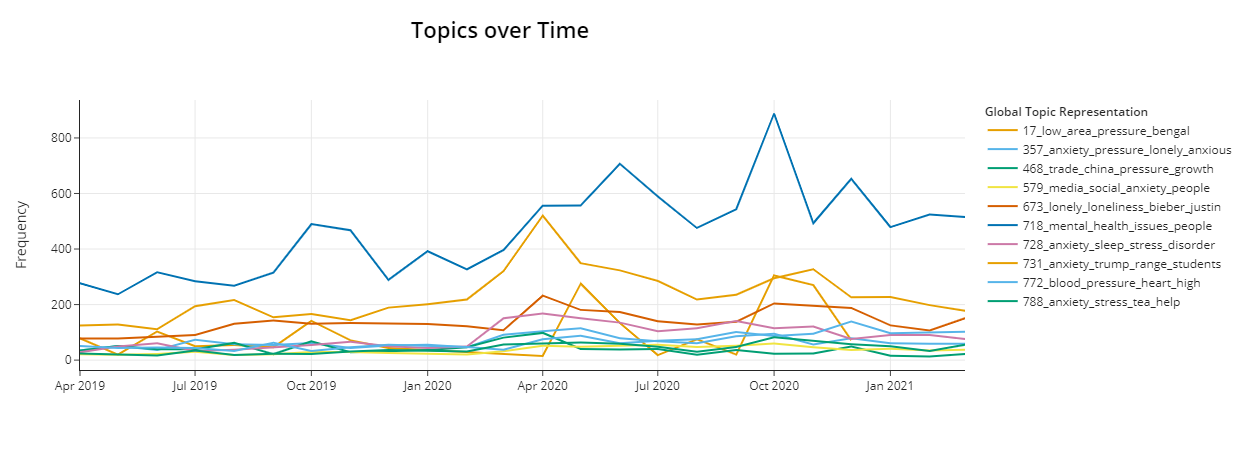

In [ ]:
fasttext = BERTopic.load('/content/drive/My Drive/indian_ft102')
ftop = np.load('/content/drive/My Drive/topic_india10ft2.npy')

In [ ]:
fasttext.visualize_topics()

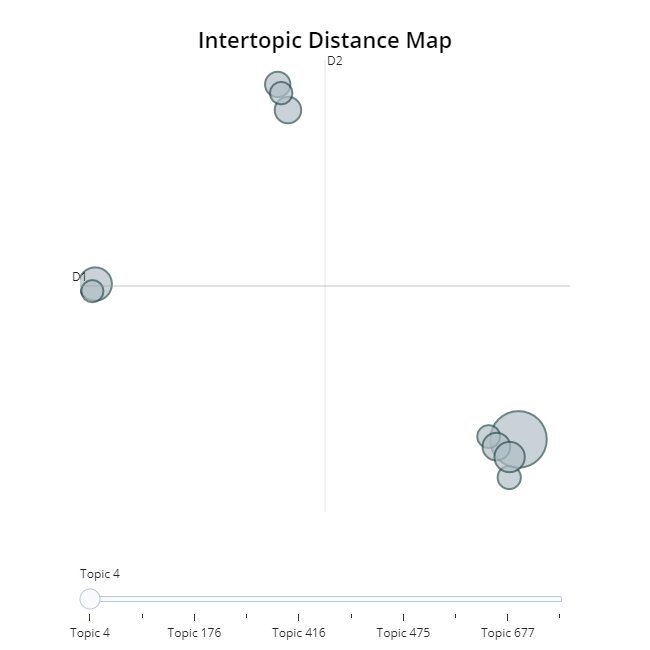

In [ ]:
fasttext.get_topics()

{-1: [('health', 0.035291830486878124),
  ('mental', 0.03472299482501809),
  ('anxiety', 0.029850034167164894),
  ('stress', 0.014452855333709701),
  ('pandemic', 0.011543933008937964),
  ('time', 0.011115561984546173),
  ('loneliness', 0.009700813131826629),
  ('physical', 0.008825243147813381),
  ('students', 0.008695059855766747),
  ('children', 0.008347134572501975)],
 4: [('bengal', 0.10226824897602482),
  ('imd', 0.08708883303095648),
  ('east', 0.05375044722229752),
  ('rainfall', 0.05328190419583811),
  ('north', 0.0519161599597743),
  ('meteorological', 0.04913861536607475),
  ('monsoon', 0.04788102144127355),
  ('coast', 0.04640869245629321),
  ('cyclonic', 0.045802237232437225),
  ('cyclone', 0.04379388894187008)],
 157: [('feel', 0.02148483491100432),
  ('time', 0.021071655431917708),
  ('think', 0.018739397327008033),
  ('anxious', 0.017547042848727847),
  ('know', 0.01611184451755364),
  ('really', 0.014367812859147096),
  ('going', 0.013251936169214766),
  ('things', 0.0

In [ ]:
topics_over_time = fasttext.topics_over_time(new_tokens, ftop, clean_times, global_tuning=False)

In [ ]:
#topics_over_time.to_json(r'/content/drive/My Drive/fasttextdf_tot.json')

In [ ]:
topics_over = topics_over_time[topics_over_time.Frequency > 5]

In [ ]:
fasttext.visualize_topics_over_time(topics_over, top_n = 10)

/usr/local/lib/python3.7/dist-packages/bertopic/_bertopic.py:829: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



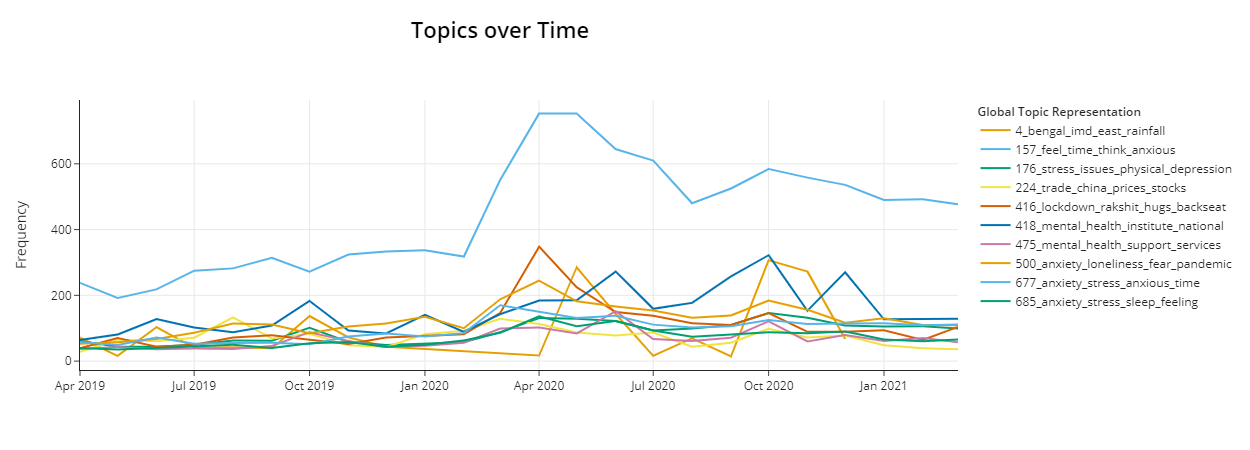

In [ ]:
w2v = BERTopic.load('/content/drive/My Drive/indian_w2v10')
topw2v = np.load('/content/drive/My Drive/topic_india10.npy')

In [ ]:
w2v.visualize_topics()

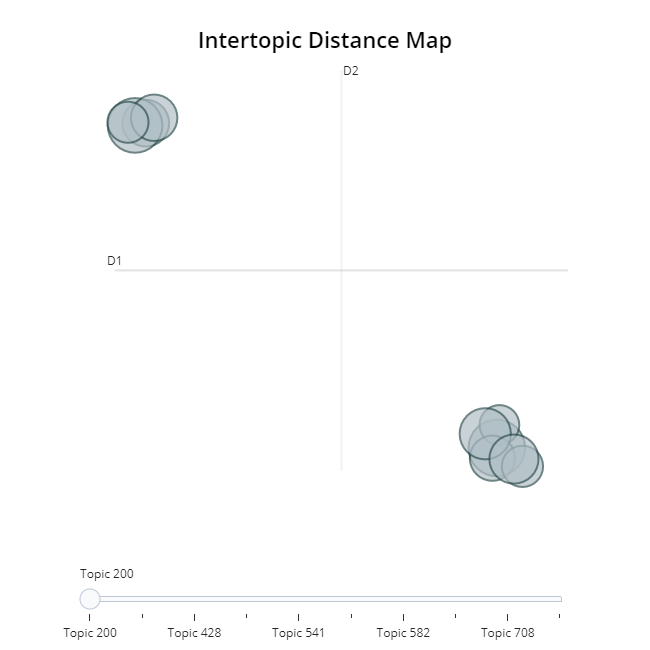

In [ ]:
w2v.get_topics()

{-1: [('anxiety', 0.031033216490165817),
  ('people', 0.01963550658544368),
  ('time', 0.015246310919666387),
  ('stress', 0.01486662611218521),
  ('life', 0.011289520329161919),
  ('pandemic', 0.011182137885335995),
  ('child', 0.010824052197856607),
  ('work', 0.010022045053402236),
  ('loneliness', 0.009665036909664873),
  ('family', 0.009522861040432373)],
 200: [('low', 0.07672876167674175),
  ('south', 0.030036819462459223),
  ('rain', 0.025981595066914585),
  ('coast', 0.025047434036964803),
  ('rainfall', 0.023918515734689387),
  ('north', 0.02352481684689269),
  ('west', 0.022114450969476313),
  ('monsoon', 0.02181572960642195),
  ('cyclone', 0.021758467735673977),
  ('cyclonic', 0.02054912290882031)],
 331: [('anxiety', 0.04199771939157532),
  ('loneliness', 0.02802081941027113),
  ('covid', 0.016967702432629444),
  ('pandemic', 0.01671980413124133),
  ('fear', 0.015969770826370737),
  ('coronavirus', 0.011117080723016839),
  ('case', 0.010624852044468273),
  ('virus', 0.0103

In [ ]:
topics_over_time = w2v.topics_over_time(new_tokens, topw2v, clean_times, global_tuning=False)

In [ ]:
#topics_over_time.to_json(r'/content/drive/My Drive/word2vecdf_tot.json')

In [ ]:
topics_over = topics_over_time[topics_over_time.Frequency > 5]

In [ ]:
w2v.visualize_topics_over_time(topics_over, top_n = 10)

/usr/local/lib/python3.7/dist-packages/bertopic/_bertopic.py:829: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



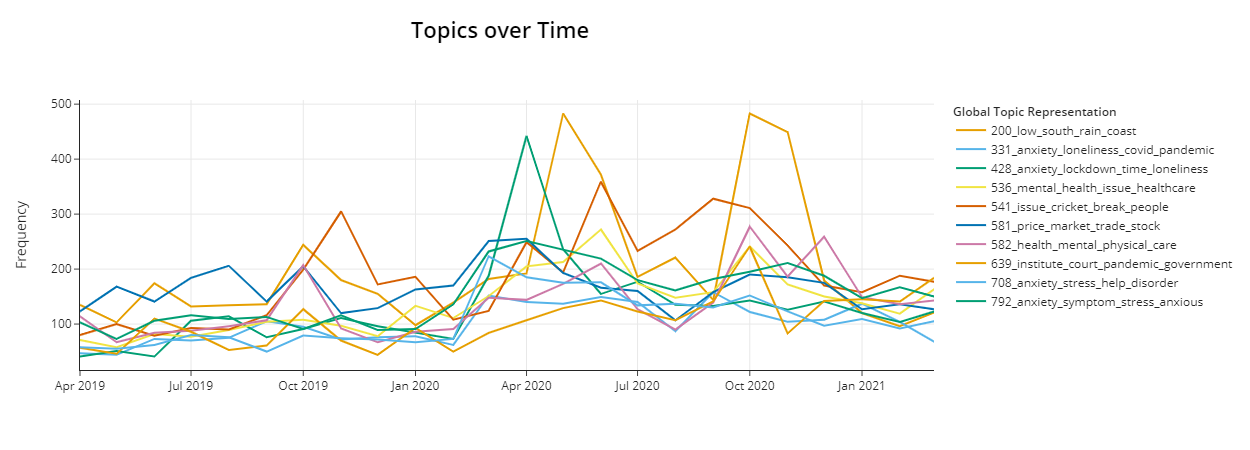

In [ ]:
fasttext_7 = BERTopic.load('/content/drive/My Drive/indian_ft7')
ftop_7 = np.load('/content/drive/My Drive/topic_india10ft7.npy')

In [ ]:
topics_over_time = fasttext_7.topics_over_time(new_tokens, ftop_7, clean_times, global_tuning=False)

In [ ]:
topics_over = topics_over_time[topics_over_time.Frequency > 5]

In [ ]:
fasttext_7.visualize_topics_over_time(topics_over, top_n = 7)

/usr/local/lib/python3.7/dist-packages/bertopic/_bertopic.py:829: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
w2v_7 = BERTopic.load('/content/drive/My Drive/indian_w2v7')
topw2v_7 = np.load('/content/drive/My Drive/topic_indiaw2v7.npy')

In [ ]:
topics_over_time = w2v_7.topics_over_time(new_tokens, topw2v_7, clean_times, global_tuning=False)

In [ ]:
topics_over = topics_over_time[topics_over_time.Frequency > 5]

In [ ]:
w2v_7.visualize_topics_over_time(topics_over, top_n = 7)

/usr/local/lib/python3.7/dist-packages/bertopic/_bertopic.py:829: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

